In [1]:
import numpy as np
import pickle
import shutil
import os
import pandas as pd
from tempfile import TemporaryDirectory
from numpy.testing import assert_equal, assert_almost_equal, assert_raises
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
class MovieDB:
    def __init__(self, path):
        self.data_dir = path
        os.makedirs(self.data_dir, exist_ok=True)
        
        return
    
    def add_movie(self, title, year, genre, director):
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(
                os.path.join(self.data_dir,'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        if os.path.isfile(os.path.join(self.data_dir,'directors.csv')):
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
            
        else:
            self.directors = pd.DataFrame(
                columns=['director_id', 'given_name', 'last_name'])
            self.directors.to_csv(os.path.join(self.data_dir,'directors.csv'),
                                  index=False) 
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
            
        ###------------directors.csv appending-------------------   
        last_name, given_name = director.split(',')
        given_name = given_name.strip()
        last_name = last_name.strip()
        
        name1_bool = self.df_dir['given_name'].str.lower().isin(
            [given_name.lower()])
        name2_bool = self.df_dir['last_name'].str.lower().isin(
            [last_name.lower()])
        
        if len(self.df_dir[(name1_bool)&(name2_bool)]) == 1:
            director_id = self.df_dir[(name1_bool)&(name2_bool)]\
                ['director_id'].item()
        else:
            new_id = len(self.df_dir) + 1

            add_dir = {'director_id': new_id, 
                      'given_name': given_name,
                      'last_name': last_name}
            df_add = pd.DataFrame(add_dir, index=[0])
            df_add.to_csv(os.path.join(self.data_dir,'directors.csv'),
                          mode='a', header=False, index=False)
            director_id = new_id
            
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
        ##------------movies.csv appending-------------------
        title_bool = self.df_movies['title'].str.lower().isin(
            [title.lower().strip()])
        year_bool = self.df_movies['year'].isin([year])
        genre_bool = self.df_movies['genre'].str.lower().isin(
            [genre.lower().strip()])
        director_id_bool = self.df_movies['director_id'].isin(
            [director_id])
        
        if len(self.df_movies[(title_bool)&(year_bool)&(genre_bool)\
                              &(director_id_bool)] == 1):
            raise MovieDBError
        else:
            movie_id = len(self.df_movies) + 1

            add_mov = {'movie_id': movie_id,
                      'title': title,
                      'year': year, 
                      'genre': genre,
                      'director_id': director_id}
            df_addmov = pd.DataFrame(add_mov, index=[0])
            df_addmov.to_csv(os.path.join(self.data_dir,'movies.csv'), 
                             mode='a', header=False, index=False)
           
        self.df_movies = pd.read_csv(os.path.join(self.data_dir,'movies.csv'))
        
        return movie_id
    
    def add_movies(self,movies):
        # check if movies.csv exists already, if not create a new file
        
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(os.path.join(
                self.data_dir,'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        
        # check if directors.csv exists already, if not create a new file
        if os.path.isfile(os.path.join(self.data_dir,'directors.csv')):
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
            
        else:
            self.directors = pd.DataFrame(columns=['director_id',
                                                   'given_name', 'last_name'])
            self.directors.to_csv(os.path.join(
                self.data_dir,'directors.csv'), index=False) 
            self.df_dir = pd.read_csv(os.path.join(
                self.data_dir,'directors.csv'))
            
            
        # create temporary variables for this function
        
        counter = 0
        new_movie_ids = []
        
        display(self.df_dir)
        # go through all the dictionary of movies in the list
        for movie in movies:
            # keep on repopulating DF for any new movies or directors added
            df_movies_dir = self.df_movies.merge(self.df_dir, how='left',
                                                 on='director_id')
            
            # check if the dictionary has all the required keys
            if 'title' in movie and 'year' in movie and 'genre' in movie and \
            'director' in movie:
                # create temporary variables when checking /creating a movie 
                #in the list
                # use strip() to clean spaces
                last_name, given_name = movie['director'].split(',')
                given_name = given_name.strip()
                last_name = last_name.strip()
                movie['title'] = movie['title'].strip()
                movie['genre'] = movie['genre'].strip()
                
                
                # check if the movie already in movies.csv and directors.csv
                if movie['title'].lower() in df_movies_dir['title'].\
                str.lower().to_list() and movie['year'] in \
                df_movies_dir['year'].to_list() and movie['genre'].lower() in\
                df_movies_dir['genre'].str.lower().to_list() and \
                given_name.lower() in \
                df_movies_dir['given_name'].str.lower().to_list() and \
                last_name.lower() in df_movies_dir['last_name'].str.lower()\
                .to_list():
                    m = movie['title']
                    print(f'Warning: movie {m} is already in the database. '
                          'Skipping...')
                    
                else:
                    ###------------directors.csv appending-------------------   
                    name1_bool = self.df_dir['given_name'].str.lower().isin(
                        [given_name.lower()])
                    name2_bool = self.df_dir['last_name'].str.lower().isin(
                        [last_name.lower()])

                    if len(self.df_dir[(name1_bool)&(name2_bool)]) == 1:
                        director_id = self.df_dir[(name1_bool)&(name2_bool)]\
                        ['director_id'].item()
                        
                    else:
                        new_id = len(pd.read_csv(
                            os.path.join(self.data_dir,'directors.csv'))) + 1
                        add_dir = {'director_id': new_id, 
                                  'given_name': given_name,
                                  'last_name': last_name}
                        df_add = pd.DataFrame(add_dir, index=[0])
                        df_add.to_csv(
                            os.path.join(self.data_dir,'directors.csv'), 
                            mode='a', header=False, index=False)
                        self.df_dir = pd.read_csv(os.path.join(
                            self.data_dir,'directors.csv'))

                        director_id = new_id
                    
                    ##------------movies.csv appending-------------------
                    movie_id = len(pd.read_csv(os.path.join(
                        self.data_dir,'movies.csv'))) + 1
                    add_mov = {'movie_id': movie_id,
                              'title': movie['title'],
                              'year': movie['year'], 
                              'genre': movie['genre'],
                              'director_id': director_id}
                    df_addmov = pd.DataFrame(add_mov, index=[0])
                    df_addmov.to_csv(os.path.join(self.data_dir,'movies.csv'),
                                     mode='a', header=False, index=False)
                    self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                              'movies.csv'))
                    
                    # append to new_movie_ids list
                    new_movie_ids.append(movie_id)
            else:
                print(f'Warning: movie index {counter} has invalid or'
                      ' incomplete information. Skipping...')
            
            # temp variable just for the index of the list of movies 
            #"to be added"
            counter += 1
        
        df_movies_dir = self.df_movies.merge(self.df_dir, how='left',
                                             on='director_id')
        display(df_movies_dir)
        
        return new_movie_ids


    def search_movies(self, title = None, year = None, genre = None,
                      director_id = None):
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))

        # check if the parameter is not present or has the correct data type
        if (type(title) == str or title == None) and \
            (type(year) == int or year == None) and \
            (type(genre) == str or genre == None) and \
            (type(director_id) == int or director_id == None):
            
            # handle none parameters
            temp_title = title
            temp_genre = genre
            if title != None:
                temp_title = temp_title.strip().lower()
            if temp_genre != None:
                temp_genre = temp_genre.strip().lower()
                
            df_temp = self.df_movies[ 
                        (self.df_movies['title'].str.lower() == temp_title) |
                        (self.df_movies['year'] == year) | 
                        (self.df_movies['genre'].str.lower() == temp_genre) | 
                        (self.df_movies['director_id'] == director_id)
                        ]
            
            # convert the column of movie_id to a list
            temp_list = df_temp['movie_id'].tolist()
            
            # check if at least one of the parameters is present
            if title == None and year == None and genre == None and \
            director_id == None:
                raise MovieDBError
            else:
                return temp_list
    def delete_movie(self, movie_id):
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            df_to_del = pd.read_csv(os.path.join(self.data_dir,'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(columns=['movie_id', 'title', 'year',
                                                'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            df_to_del = pd.read_csv(os.path.join(self.data_dir,'movies.csv'))
        

        if movie_id not in df_to_del['movie_id'].values:
            raise MovieDBError
        else:
            index = df_to_del[df_to_del['movie_id']==movie_id].index.item()
            df_done = df_to_del.drop(index)
            df_done.to_csv(os.path.join(self.data_dir,'movies.csv'),
                           index=False)
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            return
    def export_data(self):
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        if os.path.isfile(os.path.join(self.data_dir,'directors.csv')):
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
            
        else:
            self.directors = pd.DataFrame(
                columns=['director_id', 'given_name', 'last_name'])
            self.directors.to_csv(os.path.join(self.data_dir,'directors.csv'),
                                  index=False) 
            self.df_dir = pd.read_csv(os.path.join(
                self.data_dir,'directors.csv'))
            
        merged = self.df_movies.merge(self.df_dir, on='director_id',
                                      how='left').sort_values(by='movie_id')
        merged = merged.drop(['movie_id','director_id'], axis=1)
        merged.rename(columns={'given_name':'director_given_name',
                               'last_name':'director_last_name'}, inplace=True)
        return merged[['title', 'year', 'genre', 'director_last_name',\
                       'director_given_name']]
    def token_freq(self): 
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(
                self.data_dir,'movies.csv'))
            
        list_mov = self.df_movies['title'].str.lower().str.split().tolist()
        li_to_count = [item for sublist in list_mov for item in sublist]
        return Counter(li_to_count)

    def generate_statistics(self, stat):
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'),
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(
                self.data_dir,'movies.csv'))
            
        if os.path.isfile(os.path.join(self.data_dir,'directors.csv')):
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
            
        else:
            self.directors = pd.DataFrame(
                columns=['director_id', 'given_name', 'last_name'])
            self.directors.to_csv(os.path.join(self.data_dir,'directors.csv'),
                                  index=False) 
            self.df_dir = pd.read_csv(os.path.join(
                self.data_dir,'directors.csv'))
        
        if stat not in ['movie', 'genre', 'director', 'all']:
            raise MovieDBError
        else:   
            
            if stat == 'movie':
                return dict(
                    self.df_movies.groupby('year')['movie_id'].count())
            elif stat == 'genre':

                d = {}

                for a,b in self.df_movies.groupby(['genre'])['year']:

                    val = dict(self.df_movies[self.df_movies['genre']== a].\
                               groupby('year')['movie_id'].count())
                    d[a]= val
                return d
            elif stat =='director':
                df_merged = self.df_movies.merge(self.df_dir,
                                                 on='director_id', how='left')

                full_name = (df_merged['last_name'] + ', ' 
                             + df_merged['given_name'])
                df_merged['full_name'] = full_name

                d={}
                for a in df_merged.full_name.unique():
                    val = dict(df_merged[df_merged['full_name']==a].\
                               groupby('year')['movie_id'].count())
                    d[a] = val

                return d
            elif stat == 'all':
                all_d = {}

                for i in ['movie', 'genre', 'director']:
                    if i == 'movie':
                        all_val = dict(self.df_movies.\
                                       groupby('year')['movie_id'].count())
                    elif i == 'genre':
                        d_1 = {}
                        for a,b in self.df_movies.groupby(['genre'])['year']:
                            val = dict(
                                self.df_movies[self.df_movies['genre']==a]\
                                .groupby('year')['movie_id'].count())
                            d_1[a]= val
                        all_val = d_1
                    elif i == 'director':
                        df_merged = self.df_movies.merge(self.df_dir,
                                                         on='director_id',
                                                         how='left')

                        full_name = (df_merged['last_name'] + ', ' 
                                     + df_merged['given_name'])
                        df_merged['full_name'] = full_name

                        d_2={}
                        for a in df_merged.full_name.unique():
                            val = dict(
                                df_merged[df_merged['full_name']==a]\
                                .groupby('year')['movie_id'].count())
                            d_2[a] = val
                        all_val = d_2

                    all_d[i] = all_val
                return all_d
        
    def plot_statistics(self, stat):
        # check if movies.csv exists already, if not create a new file
        if os.path.isfile(os.path.join(self.data_dir,'movies.csv')):
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        else:
            self.movies = pd.DataFrame(
                columns=['movie_id', 'title', 'year', 'genre', 'director_id'])
            self.movies.to_csv(os.path.join(self.data_dir,'movies.csv'), 
                               index=False)
            self.df_movies = pd.read_csv(os.path.join(self.data_dir,
                                                      'movies.csv'))
            
        
        # check if directors.csv exists already, if not create a new file
        if os.path.isfile(os.path.join(self.data_dir,'directors.csv')):
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
            
        else:
            self.directors = pd.DataFrame(columns=['director_id',
                                                   'given_name', 'last_name'])
            self.directors.to_csv(os.path.join(self.data_dir,'directors.csv'),
                                  index=False) 
            self.df_dir = pd.read_csv(os.path.join(self.data_dir,
                                                   'directors.csv'))
        
        # create merged DF of movies and director
        df_movies_dir = self.df_movies.merge(self.df_dir, how='left',
                                             on='director_id')
        
        
        if stat == 'movie':
            gr = self.df_movies.groupby('year')['movie_id'].count()
            fig, ax = plt.subplots(1,1,figsize=(15,10))
            ax.set_ylabel('movies')
            ax.bar(gr.index,gr.values)
        elif stat == 'genre':
            temp_df = pd.DataFrame(df_movies_dir.groupby(
                ['year', 'genre'])['movie_id'].count().reset_index())
            temp_df = temp_df.pivot(index = 'year', columns = 'genre', 
                                    values = 'movie_id')
            
            plt.rcParams['figure.figsize'] = [15, 10]
            ax = temp_df.plot(kind='line', ylabel='movies', marker='o')
        elif stat == 'director':
            full_name = (df_movies_dir['last_name'] + ', ' 
                         + df_movies_dir['given_name'])
            df_movies_dir['full_name'] = full_name
            temp_df = pd.DataFrame(
                df_movies_dir.groupby(['full_name', 'year'])['movie_id'].\
                count().reset_index())
            
            # get the top 5 directors
            temp_df_dir = pd.DataFrame(temp_df.groupby(
                ['full_name'])['movie_id'].sum().reset_index())
            top_5_dir = temp_df_dir.sort_values(['movie_id','full_name'], 
                                                ascending=[0,1]).head(5)
            top_5_dir = top_5_dir['full_name'].to_list()

            
            temp_df = temp_df.pivot(index = 'year', columns = 'full_name',
                                    values = 'movie_id')

            
            temp_df = temp_df[top_5_dir]
            
            plt.rcParams['figure.figsize'] = [15, 10]
            ax = temp_df.plot(kind='line', ylabel='movies', marker = 'o')
            
#         plt.show()
        return ax
        
class MovieDBError(Exception):
    pass 

### Adding a movie to the database

In [3]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_equal(
        movie_db.add_movie('Shrek', 2001, 'Comedy', 'Adamson, Andrew'), 
        1
    )
    assert_raises(
        MovieDBError,
        lambda: movie_db.add_movie('Shrek', 2001, 'Comedy', 'Adamson, Andrew')
    )
    df_movies = pd.read_csv(os.path.join(temp_dir, 'movies.csv'))
    assert_equal(
        df_movies.columns.tolist(),
        ['movie_id', 'title', 'year', 'genre', 'director_id']
    )
    assert_equal(
        df_movies.values.tolist(), 
        [[1, 'Shrek', 2001, 'Comedy', 1]]
    )
    assert_equal(
        df_movies.index.tolist(), 
        [0]
    )
    df_directors = pd.read_csv(os.path.join(temp_dir, 'directors.csv'))
    assert_equal(
        df_directors.columns.tolist(),
        ['director_id', 'given_name', 'last_name']
    )
    assert_equal(
        df_directors.values.tolist(), 
        [[1, 'Andrew', 'Adamson']]
    )
    assert_equal(
        df_directors.index.tolist(), 
        [0]
    )

In [4]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_equal(
        movie_db.add_movie('The Matrix', 1999, 'Action', 'Wachowskis, The'), 
        1
    )
    assert_equal(
        movie_db.add_movie('Shrek', 2001, 'Comedy', 'Adamson, Andrew'), 
        2
    )
    assert_equal(
        movie_db.add_movie('The Matrix Reloaded', 2003, 'Action', 
                           'Wachowskis, The'), 
        3
    )
    assert_equal(
        movie_db.add_movie('The Matrix Revolutions', 2003, 'Action', 
                           'Wachowskis, The'), 
        4
    )
    assert_raises(
        MovieDBError,
        lambda: movie_db.add_movie('Shrek', 2001, 'Comedy', 'Adamson, Andrew')
    )

In [5]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_equal(
        movie_db.add_movie('Spider-Man', 1977, 'Action', 
                           'Swackhamer, Egbert Warnderink'), 
        1
    )
    assert_equal(
        movie_db.add_movie('Spider-Man', 2002, 'Action', 'Raimi, Sam'),
        2
    )
    assert_equal(
        movie_db.add_movie('Spider-Man', 2002, 'Animation', 'Raimi, Sam'),
        3
    )
    assert_raises(
        MovieDBError,
        lambda: movie_db.add_movie('Spider-Man ', 2002, ' Action', 
                                   ' Raimi,  Sam ')
    )
    

### Adding movies in the database

In [6]:
%%capture out
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    movie_db.add_movies([
        {'title': 'The Matrix', 'year': 1999, 'genre': 'Action', 
         'director': 'Wachowskis, The'}, 
        {'title': 'Shrek',  'genre': 'Comedy', 'director': 'Adamson, Andrew', 
         'year': 2001},
        {'year': 2003, 'genre': 'Action', 'title': 'The Matrix Reloaded'},
        {'title': 'Shrek', 'year': 2001, 'genre': 'Comedy', 
         'director': 'Adamson, Andrew'},
        {'title': 'The Matrix Revolutions','year': 2003, 'genre': 'Action', 
         'director': 'Wachowskis, The'}
    ])

In [7]:
assert_equal(
    out.stdout,
    'Warning: movie index 2 has invalid or incomplete information. '
    'Skipping...\n'
    'Warning: movie Shrek is already in the database. Skipping...\n'
)

### Deleting a movie in the database

In [8]:
### testing delete_movie assertions
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_raises(MovieDBError, lambda: movie_db.delete_movie(1))
    shutil.copy('movies_test.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test.csv', os.path.join(temp_dir, 'directors.csv'))
    movie_db.delete_movie(1)
    assert_raises(MovieDBError, lambda: movie_db.delete_movie(1))

### Searching for movies in the database

In [9]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_raises(MovieDBError, lambda: movie_db.search_movies())
    assert_equal(movie_db.search_movies(title='Spider-man'), [])
    shutil.copy('movies_test.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test.csv', os.path.join(temp_dir, 'directors.csv'))
    assert_raises(MovieDBError, lambda: movie_db.search_movies())
    assert_equal(movie_db.search_movies(title='Spider-man'), [5, 6, 7])
    assert_equal(movie_db.search_movies(year=2002), [6, 7])

### Exporting data

In [10]:
### testing exporting data assertions
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    df_export = movie_db.export_data()
    assert_equal(isinstance(df_export, pd.DataFrame), True)
    assert_equal(
        df_export.columns.tolist(), 
        ['title', 'year', 'genre', 'director_last_name', 
         'director_given_name']
    )
    assert_equal(len(df_export), 0)
    shutil.copy('movies_test.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test.csv', os.path.join(temp_dir, 'directors.csv'))
    df_export = movie_db.export_data()
    assert_equal(isinstance(df_export, pd.DataFrame), True)
    assert_equal(
        df_export.columns.tolist(), 
        ['title', 'year', 'genre', 'director_last_name', 
         'director_given_name']
    )
    assert_equal(
        df_export.iloc[:3].values.tolist(),
        [['The Matrix', 1999, 'Action', 'Wachowskis', 'The'],
         ['Shrek', 2001, 'Comedy', 'Adamson', 'Andrew'],
         ['The Matrix Reloaded', 2003, 'Action', 'Wachowskis', 'The']]
    )

### Plotting statistics

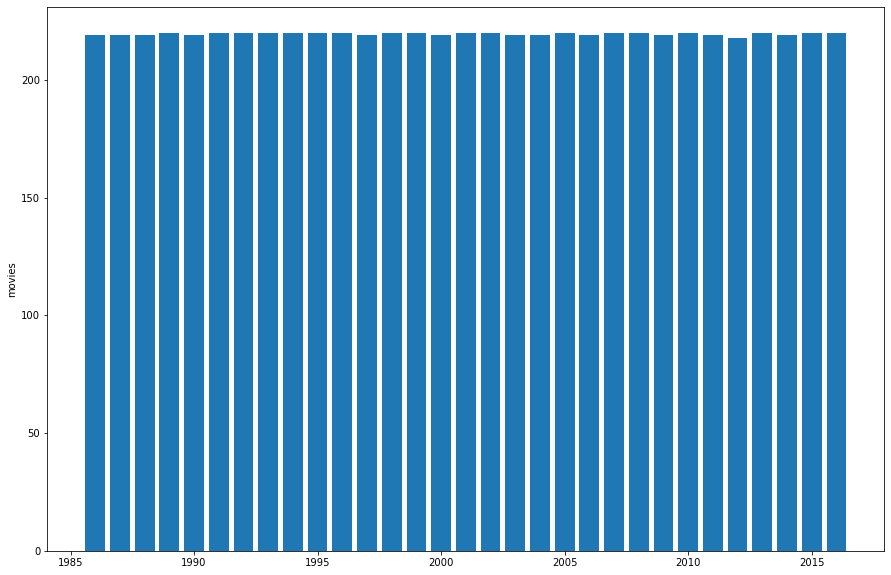

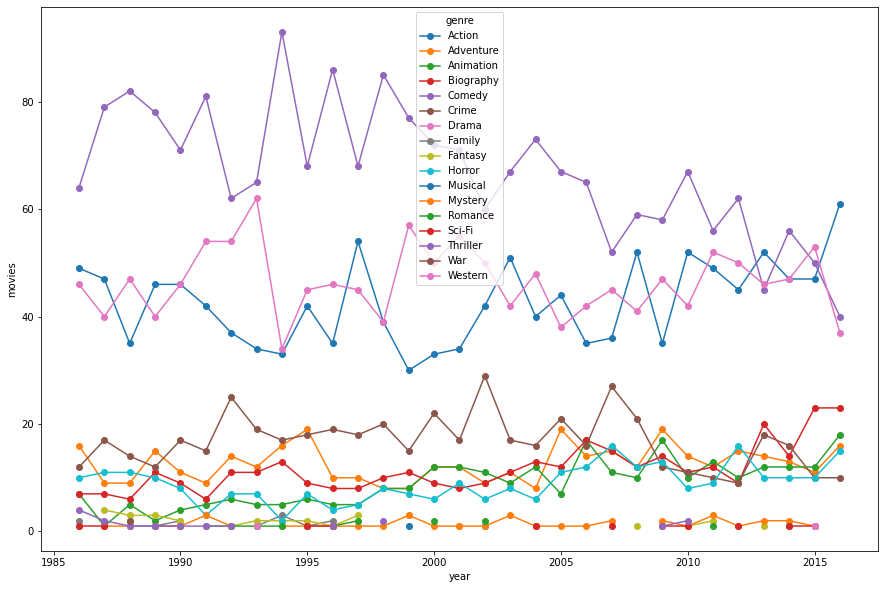

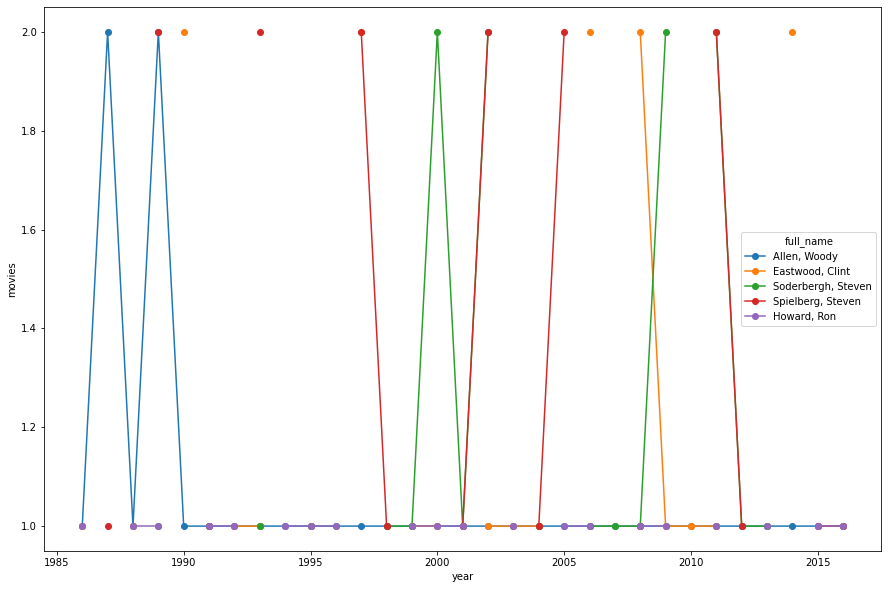

In [11]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    shutil.copy('movies_test2.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test2.csv', 
                os.path.join(temp_dir, 'directors.csv'))
    ax_movie = movie_db.plot_statistics('movie')
    ax_movie.get_figure().canvas.draw()
    assert_equal(
        [t.get_text() for t in ax_movie.get_xticklabels()],
        ['1980', '1985', '1990', '1995', '2000', 
         '2005', '2010', '2015', '2020']
    )
    assert_equal(
        [t.get_text() for t in ax_movie.get_yticklabels()],
        ['0', '50', '100', '150', '200', '250']
    )
    assert_equal(ax_movie.get_ylabel(), 'movies')
    assert_equal(
        [h.get_height() for h in ax_movie.patches],
        [219, 219, 219, 220, 219, 220, 220, 220, 220, 220, 220, 219, 220, 220,
         219, 220, 220, 219, 219, 220, 219, 220, 220, 219, 220, 219, 218, 220,
         219, 220, 220]
    )
    ax_genre = movie_db.plot_statistics('genre')
    ax_genre.get_figure().canvas.draw()
    assert_equal(
        [t.get_text() for t in ax_genre.get_xticklabels()],
        ['1980', '1985', '1990', '1995', '2000', 
         '2005', '2010', '2015', '2020']
    )
    assert_equal(
        [t.get_text() for t in ax_genre.get_yticklabels()],
        ['−20', '0', '20', '40', '60', '80', '100']
    )
    assert_equal(ax_genre.get_ylabel(), 'movies')
    assert_equal(len(ax_genre.lines), 17)
    assert_equal(
        ax_genre.lines[0].get_xdata().tolist(),
        [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
         1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
         2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
    )
    assert_equal(
        ax_genre.lines[0].get_ydata().tolist(),
        [49, 47, 35, 46, 46, 42, 37, 34, 33, 42, 35, 54, 39, 30, 33, 34, 42,
         51, 40, 44, 35, 36, 52, 35, 52, 49, 45, 52, 47, 47, 61]
    )
    assert_equal(ax_genre.lines[0].get_marker(), 'o')
    assert_equal(ax_genre.lines[0].get_ls(), '-')
    assert_equal(
        [t.get_text() for t in ax_genre.legend_.get_texts()[:5]],
        ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy']
    )
    ax_director = movie_db.plot_statistics('director')
    ax_director.get_figure().canvas.draw()
    assert_equal(
        [t.get_text() for t in ax_director.get_xticklabels()],
        ['1980', '1985', '1990', '1995', '2000', 
         '2005', '2010', '2015', '2020']
    )
    assert_equal(
        [t.get_text() for t in ax_director.get_yticklabels()],
        ['0.8', '1.0', '1.2', '1.4', '1.6', '1.8', '2.0', '2.2']
    )
    assert_equal(ax_director.get_ylabel(), 'movies')
    assert_equal(len(ax_director.lines), 5)
    assert_equal(
        ax_director.lines[0].get_xdata().tolist(),
        [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
         1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
         2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
    )
    assert_equal(
        ax_director.lines[0].get_ydata().tolist(),
        [1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]
    )
    assert_equal(ax_director.lines[0].get_marker(), 'o')
    assert_equal(ax_director.lines[0].get_ls(), '-')
    assert_equal(
        [t.get_text() for t in ax_director.legend_.get_texts()[:3]],
        ['Allen, Woody', 'Eastwood, Clint', 'Soderbergh, Steven']
    )

### Token frequency

In [12]:
### testing token frequency
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_equal(movie_db.token_freq(), {})
    shutil.copy('movies_test2.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test2.csv', 
                os.path.join(temp_dir, 'directors.csv'))
    token_freq = movie_db.token_freq()
    assert_equal(len(token_freq), 6534)
    assert_equal(token_freq['the'], 1874)
    assert_equal(token_freq['spider-man'], 5)

### Generating Statistics

In [13]:
### testing genere_statistics
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    assert_raises(MovieDBError, lambda: movie_db.generate_statistics('Movie'))
    assert_equal(movie_db.generate_statistics('movie'), {})
    assert_equal(movie_db.generate_statistics('genre'), {})
    assert_equal(movie_db.generate_statistics('director'), {})
    assert_equal(
        movie_db.generate_statistics('all'), 
        {'movie': {}, 'genre': {}, 'director': {}}
    )
    shutil.copy('movies_test2.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test2.csv', 
                os.path.join(temp_dir, 'directors.csv'))
    stats_movie = movie_db.generate_statistics('movie')
    assert_equal(len(stats_movie), 31)
    assert_equal(stats_movie[2007], 220)
    assert_equal(stats_movie[2016], 220)

In [14]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    shutil.copy('movies_test2.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test2.csv', 
                os.path.join(temp_dir, 'directors.csv'))
    stats_genre = movie_db.generate_statistics('genre')
    assert_equal(len(stats_genre), 17)
    assert_equal(len(stats_genre['Adventure']), 31)
    assert_equal(
        stats_genre['Adventure'],
        {2009: 19, 2005: 19, 1995: 19, 1986: 16, 1994: 16, 2016: 16, 2012: 15,
         2007: 15, 1989: 15, 1992: 14, 2013: 14, 2010: 14, 2006: 14, 2014: 13,
         1993: 12, 2011: 12, 2008: 12, 2001: 12, 2000: 12, 2003: 11, 1990: 11,
         2015: 11, 1997: 10, 1996: 10, 2002: 9, 1987: 9, 1988: 9, 1991: 9,
         1999: 8, 1998: 8, 2004: 8}
    )
    stats_director = movie_db.generate_statistics('director')
    assert_equal(len(stats_director), 2753)
    assert_equal(
        stats_director['Spielberg, Steven'],
        {1989: 2, 1993: 2, 1997: 2, 2002: 2, 2005: 2, 2011: 2, 2016: 1,
         1987: 1, 1991: 1, 1998: 1, 2001: 1, 2004: 1, 2008: 1, 2012: 1,
         2015: 1}
    )
    stats_all = movie_db.generate_statistics('all')
    assert_equal(set(stats_all.keys()), {'movie', 'genre', 'director'})
    assert_equal(len(stats_all['movie']), 31)
    assert_equal(stats_all['movie'][2007], 220)
    assert_equal(stats_all['movie'][2016], 220)
    assert_equal(len(stats_all['genre']), 17)
    assert_equal(len(stats_all['genre']['Adventure']), 31)
    assert_equal(
        stats_all['genre']['Adventure'],
        {2009: 19, 2005: 19, 1995: 19, 1986: 16, 1994: 16, 2016: 16, 2012: 15,
         2007: 15, 1989: 15, 1992: 14, 2013: 14, 2010: 14, 2006: 14, 2014: 13,
         1993: 12, 2011: 12, 2008: 12, 2001: 12, 2000: 12, 2003: 11, 1990: 11,
         2015: 11, 1997: 10, 1996: 10, 2002: 9, 1987: 9, 1988: 9, 1991: 9,
         1999: 8, 1998: 8, 2004: 8}
    )
    assert_equal(len(stats_all['director']), 2753)
    assert_equal(
        stats_all['director']['Spielberg, Steven'],
        {1989: 2, 1993: 2, 1997: 2, 2002: 2, 2005: 2, 2011: 2, 2016: 1,
         1987: 1, 1991: 1, 1998: 1, 2001: 1, 2004: 1, 2008: 1, 2012: 1,
         2015: 1}
    )

In [15]:
with TemporaryDirectory() as temp_dir:
    movie_db = MovieDB(temp_dir)
    shutil.copy('movies_test2.csv', os.path.join(temp_dir, 'movies.csv'))
    shutil.copy('directors_test2.csv', 
                os.path.join(temp_dir, 'directors.csv'))
    stats_genre = movie_db.generate_statistics('genre')
    assert_equal(len(stats_genre), 17)
    assert_equal(len(stats_genre['Adventure']), 31)
    assert_equal(
        stats_genre['Adventure'],
        {2009: 19, 2005: 19, 1995: 19, 1986: 16, 1994: 16, 2016: 16, 2012: 15,
         2007: 15, 1989: 15, 1992: 14, 2013: 14, 2010: 14, 2006: 14, 2014: 13,
         1993: 12, 2011: 12, 2008: 12, 2001: 12, 2000: 12, 2003: 11, 1990: 11,
         2015: 11, 1997: 10, 1996: 10, 2002: 9, 1987: 9, 1988: 9, 1991: 9,
         1999: 8, 1998: 8, 2004: 8}
    )
    stats_director = movie_db.generate_statistics('director')
    assert_equal(len(stats_director), 2753)
    assert_equal(
        stats_director['Spielberg, Steven'],
        {1989: 2, 1993: 2, 1997: 2, 2002: 2, 2005: 2, 2011: 2, 2016: 1,
         1987: 1, 1991: 1, 1998: 1, 2001: 1, 2004: 1, 2008: 1, 2012: 1,
         2015: 1}
    )
    stats_all = movie_db.generate_statistics('all')
    assert_equal(set(stats_all.keys()), {'movie', 'genre', 'director'})
    assert_equal(len(stats_all['movie']), 31)
    assert_equal(stats_all['movie'][2007], 220)
    assert_equal(stats_all['movie'][2016], 220)
    assert_equal(len(stats_all['genre']), 17)
    assert_equal(len(stats_all['genre']['Adventure']), 31)
    assert_equal(
        stats_all['genre']['Adventure'],
        {2009: 19, 2005: 19, 1995: 19, 1986: 16, 1994: 16, 2016: 16, 2012: 15,
         2007: 15, 1989: 15, 1992: 14, 2013: 14, 2010: 14, 2006: 14, 2014: 13,
         1993: 12, 2011: 12, 2008: 12, 2001: 12, 2000: 12, 2003: 11, 1990: 11,
         2015: 11, 1997: 10, 1996: 10, 2002: 9, 1987: 9, 1988: 9, 1991: 9,
         1999: 8, 1998: 8, 2004: 8}
    )
    assert_equal(len(stats_all['director']), 2753)
    assert_equal(
        stats_all['director']['Spielberg, Steven'],
        {1989: 2, 1993: 2, 1997: 2, 2002: 2, 2005: 2, 2011: 2, 2016: 1,
         1987: 1, 1991: 1, 1998: 1, 2001: 1, 2004: 1, 2008: 1, 2012: 1,
         2015: 1}
    )